In [1]:
!nvidia-smi

Wed Feb 17 08:35:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0 Off |                  N/A |
| 57%   82C    P2   124W / 151W |   4351MiB /  8119MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1070    Off  | 00000000:02:00.0 Off |                  N/A |
| 57%   

In [2]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import yaml
import scipy
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow as tf
import time


In [3]:
from train import etl, chunckify, total_days, look_back, look_forward

In [11]:
final_list = []
symbols = [
    'IWM','SPY','QQQ','GLD','SLV','TSLA'
]
ticker_list = yf.Tickers(' '.join(symbols))

for ticker in ticker_list.tickers:
    history = ticker.history(period="max")
    print(ticker.ticker,history.shape)
    arr = etl(history)
    tmp = arr[-1*total_days:]
    assert(tmp.shape == (total_days,4))
    #x,y = tmp[:look_back,:],tmp[-1*look_forward:,:]
    x = tmp[-1*look_back:,:]
    y = tmp[-1*look_forward:,:]
    y[:,:]=0
    final_list.append((x,y))

IWM (5213, 7)
SPY (7063, 7)
QQQ (5521, 7)
GLD (4088, 7)
SLV (3726, 7)
TSLA (2677, 7)


In [12]:
len(final_list),final_list[0][0].shape,final_list[0][1].shape

(6, (125, 4), (10, 4))

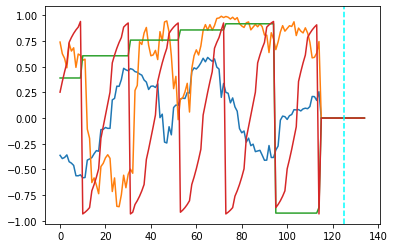

In [13]:
a=final_list[0][0]
b=final_list[0][1]
plt.plot(np.concatenate([a,b]))
plt.axvline(look_back,linestyle='--',color='cyan')

In [14]:
X = np.stack([x[0][:,:] for x in final_list],axis=0).astype(np.float32)
y = np.stack([x[1][:,:] for x in final_list],axis=0).astype(np.float32)
X_test, y_test = X, y
print(X_test.shape,y_test.shape)

(6, 125, 4) (6, 10, 4)


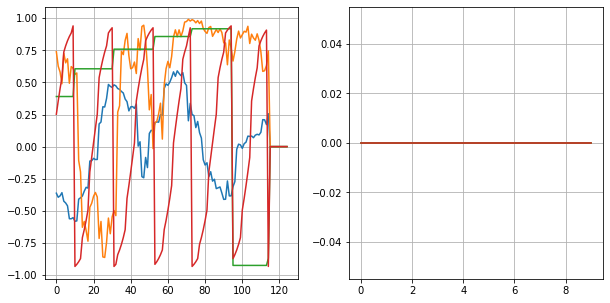

In [16]:
ind = 0
plt.figure(0,figsize=(10,5))
plt.subplot(121)
plt.plot(X_test[ind,:])
plt.grid(True)
plt.subplot(122)
plt.plot(y_test[ind,:])
plt.grid(True)

(811, 11)


<Figure size 432x288 with 0 Axes>

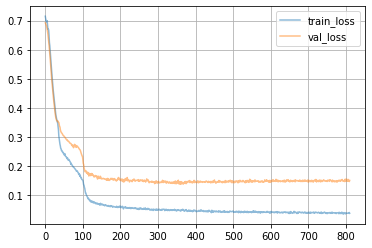

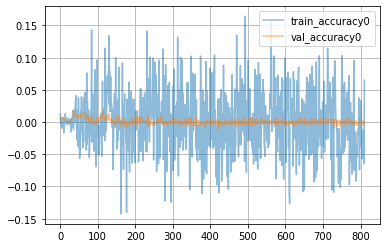

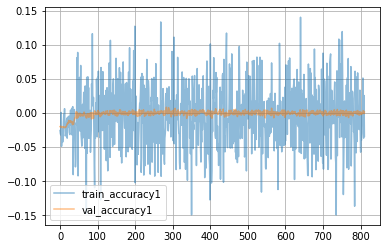

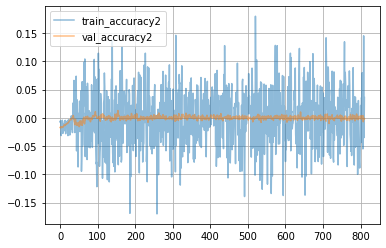

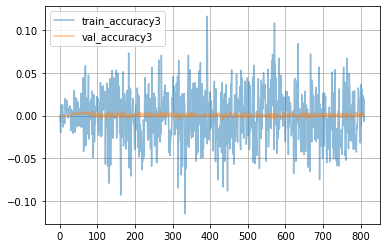

In [17]:
# check history is good prior front testing

with open('history.yml','r') as f:
    history = yaml.unsafe_load(f.read())

df = pd.DataFrame(history)
print(df.shape)
plt.figure(0)
df[['train_loss','val_loss']].plot(alpha=0.5)
plt.grid(True)
plt.figure(1)
df[['train_accuracy0','val_accuracy0']].plot(alpha=0.5)
plt.grid(True)
plt.figure(2)
df[['train_accuracy1','val_accuracy1']].plot(alpha=0.5)
plt.grid(True)
plt.figure(3)
df[['train_accuracy2','val_accuracy2']].plot(alpha=0.5)
plt.grid(True)
plt.figure(4)
df[['train_accuracy3','val_accuracy3']].plot(alpha=0.5)
plt.grid(True)


In [18]:

input_seq_len = 125
target_seq_len = 10
batch_size = 32

num_layers = 4
d_model = 4
dff = 4
num_heads = 4
dropout_rate = 0.1

from train import Transformer,CustomSchedule,create_masks


In [19]:
#loss_object = tf.keras.losses.Huber(delta=1.0)
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_sum(loss_)

# https://stackoverflow.com/a/58890795/868736
def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))  
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

#"acc..."
def accuracy_function(real, pred, axis=0):
    y_true, y_pred = real[:,:,axis],pred[:,:,axis]
    accuracies = correlation(y_pred, y_true)
    return accuracies

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy0 = tf.keras.metrics.Mean(name='train_accuracy0')
train_accuracy1 = tf.keras.metrics.Mean(name='train_accuracy1')
train_accuracy2 = tf.keras.metrics.Mean(name='train_accuracy2')
train_accuracy3 = tf.keras.metrics.Mean(name='train_accuracy3')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy0 = tf.keras.metrics.Mean(name='val_accuracy0')
val_accuracy1 = tf.keras.metrics.Mean(name='val_accuracy1')
val_accuracy2 = tf.keras.metrics.Mean(name='val_accuracy2')
val_accuracy3 = tf.keras.metrics.Mean(name='val_accuracy3')

#############

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

########

transformer = Transformer(num_layers, d_model, num_heads, dff ,rate=dropout_rate,target_seq_len=target_seq_len)

########

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [20]:
import numpy as np
import tensorflow as tf
import scipy.stats as measures
import sklearn.metrics as metrics

def correlationMetric(x, y, axis=None):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))  
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

In [23]:
def evaluate(inp,tar):
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp[:,:,0], tar[:,:,0])
    
    predictions, attention_weights = transformer(inp, tar,
                                                 False,
                                                 enc_padding_mask,
                                                 look_ahead_mask,
                                                 dec_padding_mask)

    return predictions, attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

evaluate(X_test[s:s+i,:,:],y_test[s:s+i,:,:])

(6, 125, 4) (6, 10, 4)


In [169]:
s = 0
i = 10
result, attention_weights = evaluate(X_test[s:s+i,:,:],y_test[s:s+i,:,:])
print(result.numpy().shape)

(6, 10, 4)


(6, 10) (6, 10)
(6, 10) (6, 10)
(6, 10) (6, 10)
(6, 10) (6, 10)


label  pearsonr  corrcoef   n
0   volatility  0.111045  0.111045  10
1  return_mean  0.437126  0.437126  10
2        month -0.041353 -0.041353  10
3          day  0.392314  0.392314  10

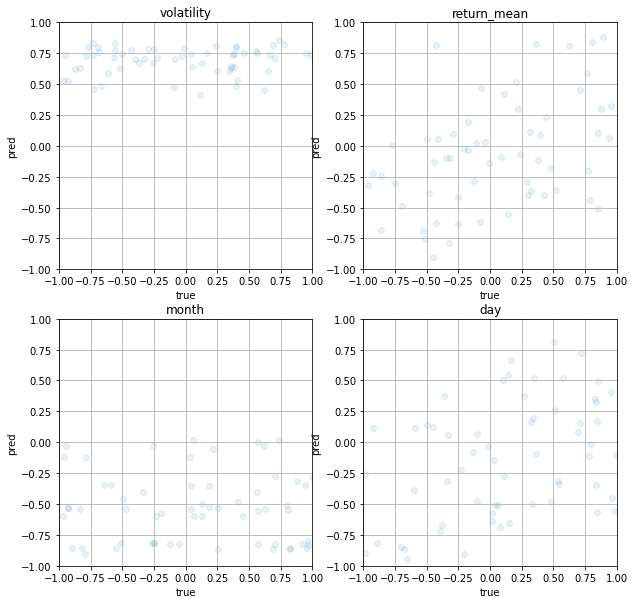

In [170]:
plt.figure(figsize=(10,10))
blob = []
for x,label,subplot in zip(range(4),['volatility','return_mean','month','day'],(221,222,223,224)):
    my_true = y_test[s:s+i,:,x]
    my_pred = result[:,:,x].numpy()
    plt.subplot(subplot)
    print(my_true.shape,my_pred.shape)
    plt.scatter(my_true,my_pred,alpha=0.1)
    plt.title(label)
    plt.grid(True)
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    corrcoef = np.corrcoef(my_true.ravel(),my_pred.ravel())[0,1]
    r = correlationMetric(my_true,my_pred).numpy()
    blob.append(dict(label=label,pearsonr=r,corrcoef=corrcoef,n=i))
df=pd.DataFrame(blob)
df

In [171]:
#plt.plot(X_test[:,:,0].T)

0 (1, 125, 4) (1, 10, 4)
1 (1, 125, 4) (1, 10, 4)
2 (1, 125, 4) (1, 10, 4)
3 (1, 125, 4) (1, 10, 4)
4 (1, 125, 4) (1, 10, 4)
5 (1, 125, 4) (1, 10, 4)


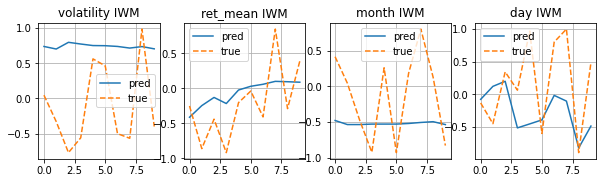

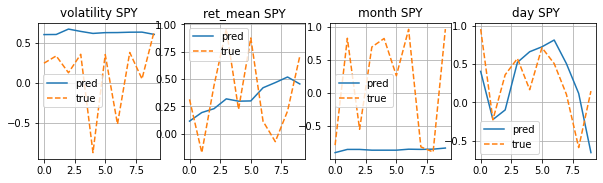

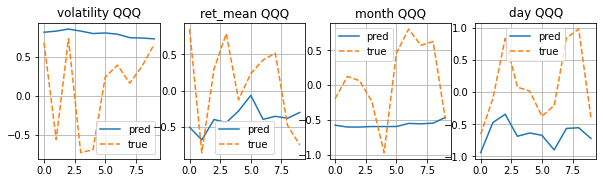

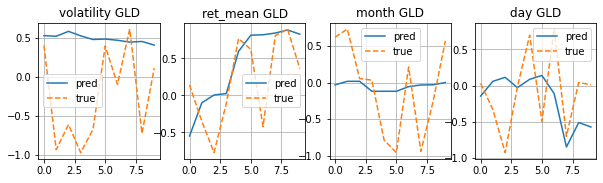

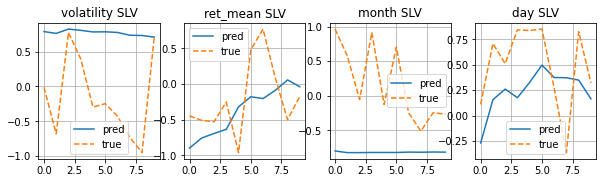

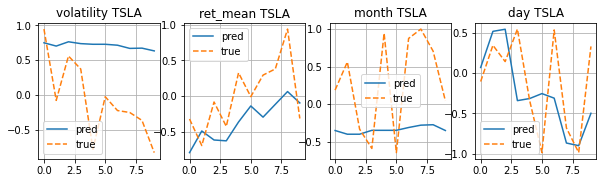

In [172]:
norm = False# True#
corr = {}
xmax = X_test.shape[0]
ind_list = list(np.arange(0,xmax,1))

for ticker,x in zip(symbols,ind_list):
    inp,tar = X_test[x,:].squeeze(),y_test[x,:].squeeze()
    inp = np.expand_dims(inp,axis=0)
    tar = np.expand_dims(tar,axis=0)
    result, attention_weights = evaluate(inp,tar)
    print(x,inp.shape,tar.shape)
    for ind,subplot,title in [
        (0,141,'volatility'),
        (1,142,'ret_mean'),
        (2,143,'month'),
        (3,144,'day')

    ]:
        pred = result.numpy().squeeze()[:,ind]
        true = tar.squeeze()[:,ind]
        if norm:
            pred/=result.numpy().squeeze()[0,ind]
            true/=tar.squeeze()[0,ind]
        title = f'{title} {ticker}'
        plt.figure(x,figsize=(10,2.5))
        plt.subplot(subplot)
        plt.plot(pred,label='pred')
        plt.plot(true,linestyle='--',label='true')
        plt.legend()
        plt.title(title)
        plt.grid(True)
        